In [16]:
import pandas as pd
import pyspark
import pyspark.sql.functions as F
import matplotlib.pyplot as plt

import os
import re

dpath = os.path.expanduser('~/Dropbox/Projects/data/')

time: 2.74 ms


In [2]:
%matplotlib inline

In [3]:
# %install_ext https://raw.github.com/cpcloud/ipython-autotime/master/autotime.py
%load_ext autotime

In [4]:
icd9 = pd.read_excel(dpath + 'icd9/CMS32_DESC_LONG_SHORT_DX.xlsx')
icd9.columns = ['icd9', 'long', 'short']

icd9.head()

,icd9,long,short
0,0010,Cholera due to vibrio cholerae,Cholera d/t vib cholerae
1,0011,Cholera due to vibrio cholerae el tor,Cholera d/t vib el tor
2,0019,"Cholera, unspecified",Cholera NOS
3,0020,Typhoid fever,Typhoid fever
4,0021,Paratyphoid fever A,Paratyphoid fever a


time: 1.03 s


In [5]:
icd = spark.createDataFrame(icd9)
icd = icd.withColumn('long', F.regexp_replace(F.lower(icd.long), ',', ''))
icd.show(truncate=False)

+-----+------------------------------------------+------------------------+
|icd9 |long                                      |short                   |
+-----+------------------------------------------+------------------------+
|0010 |cholera due to vibrio cholerae            |Cholera d/t vib cholerae|
|0011 |cholera due to vibrio cholerae el tor     |Cholera d/t vib el tor  |
|0019 |cholera unspecified                       |Cholera NOS             |
|0020 |typhoid fever                             |Typhoid fever           |
|0021 |paratyphoid fever a                       |Paratyphoid fever a     |
|0022 |paratyphoid fever b                       |Paratyphoid fever b     |
|0023 |paratyphoid fever c                       |Paratyphoid fever c     |
|0029 |paratyphoid fever unspecified             |Paratyphoid fever NOS   |
|0030 |salmonella gastroenteritis                |Salmonella enteritis    |
|0031 |salmonella septicemia                     |Salmonella septicemia   |
|00320|local

In [6]:
from pyspark.ml.feature import Tokenizer

tokenizer = Tokenizer(inputCol="long", outputCol="words")
wordsData = tokenizer.transform(icd)
wordsData.select('words').show(truncate=False)

+-----------------------------------------------+
|words                                          |
+-----------------------------------------------+
|[cholera, due, to, vibrio, cholerae]           |
|[cholera, due, to, vibrio, cholerae, el, tor]  |
|[cholera, unspecified]                         |
|[typhoid, fever]                               |
|[paratyphoid, fever, a]                        |
|[paratyphoid, fever, b]                        |
|[paratyphoid, fever, c]                        |
|[paratyphoid, fever, unspecified]              |
|[salmonella, gastroenteritis]                  |
|[salmonella, septicemia]                       |
|[localized, salmonella, infection, unspecified]|
|[salmonella, meningitis]                       |
|[salmonella, pneumonia]                        |
|[salmonella, arthritis]                        |
|[salmonella, osteomyelitis]                    |
|[other, localized, salmonella, infections]     |
|[other, specified, salmonella, infections]     |


In [7]:
from pyspark.ml.feature import StopWordsRemover

remover = StopWordsRemover(inputCol="words", outputCol="filtered")
filteredData = remover.transform(wordsData)
filteredData.select('filtered').show(truncate=False)

+-----------------------------------------------+
|filtered                                       |
+-----------------------------------------------+
|[cholera, due, vibrio, cholerae]               |
|[cholera, due, vibrio, cholerae, el, tor]      |
|[cholera, unspecified]                         |
|[typhoid, fever]                               |
|[paratyphoid, fever]                           |
|[paratyphoid, fever, b]                        |
|[paratyphoid, fever, c]                        |
|[paratyphoid, fever, unspecified]              |
|[salmonella, gastroenteritis]                  |
|[salmonella, septicemia]                       |
|[localized, salmonella, infection, unspecified]|
|[salmonella, meningitis]                       |
|[salmonella, pneumonia]                        |
|[salmonella, arthritis]                        |
|[salmonella, osteomyelitis]                    |
|[localized, salmonella, infections]            |
|[specified, salmonella, infections]            |


In [8]:
import itertools
rows_list = []
# for r in filteredData.limit(5).select('filtered').rdd.map(lambda r: list(r)[0]).collect():
for r in filteredData.select('filtered').rdd.map(lambda r: list(r)[0]).collect():
    r = [i.encode('utf-8') for i in r]
# permutations are for directional
    for pair in itertools.combinations(r, r=2):
#         print pair
        if pair[0] > pair[1]:
            a, b = pair[1], pair[0]
        else:
            a, b = pair[0], pair[1]
        dict1 = {'n1': a, 'n2': b}
        rows_list.append(dict1)

df = pd.DataFrame(rows_list)
df.head()

,n1,n2
0,cholera,due
1,cholera,vibrio
2,cholera,cholerae
3,due,vibrio
4,cholerae,due


time: 1.09 s


In [ ]:
dfc = df.groupby(['n1', 'n2']).size().reset_index()
dfc.columns = ['n1', 'n2', 'c']
dfc.head()

In [40]:
import networkx as nx
G=nx.Graph()
# G.clear()

for r in dfc[dfc.c > 3].iterrows():
#     print r[1][0], r[1][1], r[1][2]
    G.add_edge(r[1][0], r[1][1], weight = r[1][2])

time: 1.4 s


In [ ]:
# print G.nodes()
print G.edges()

In [ ]:
nx.draw(G)
# nx.draw_random(G)
# nx.draw_circular(G)
# nx.draw_spectral(G)
plt.show()

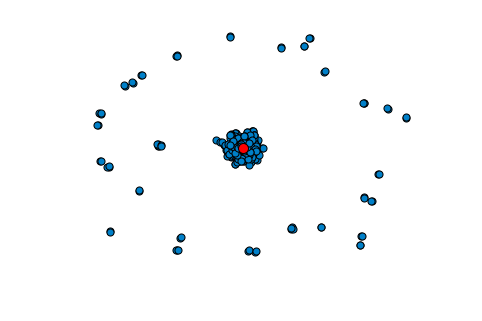

time: 13 s


In [42]:
from operator import itemgetter

# Accessing the highest degree node
center, degree = sorted(G.degree().items(), key=itemgetter(1), reverse=True)[0]

# A special type of subgraph
ego = nx.ego_graph(G, center)

# pos = nx.spring_layout(G)
pos=nx.fruchterman_reingold_layout(G)


nx.draw(G, pos, node_color='#0080C9', edge_color='#cccccc', node_size=50)
nx.draw_networkx_nodes(G, pos, nodelist=[center], node_size=100, node_color="r")
plt.show()

In [19]:
import plotly.plotly as py
from plotly.graph_objs import *

time: 1.61 s


In [22]:
labels=list(G.nodes())
N = len(labels)
E=[e for e in G.edges()]# list of edges

time: 2.95 ms


In [33]:
N

288

time: 1.88 ms


In [32]:
pos=nx.fruchterman_reingold_layout(G)

Xv=[pos[k][0] for k in range(N)]
Yv=[pos[k][1] for k in range(N)]
Xed=[]
Yed=[]
for edge in E:
    Xed+=[pos[edge[0]][0],pos[edge[1]][0], None]
    Yed+=[pos[edge[0]][1],pos[edge[1]][1], None] 
    
trace3=Scatter(x=Xed,
               y=Yed,
               mode='lines',
               line=Line(color='rgb(210,210,210)', width=1),
               hoverinfo='none'
               )
trace4=Scatter(x=Xv,
               y=Yv,
               mode='markers',
               name='net',
               marker=Marker(symbol='dot',
                             size=5, 
                             color='#6959CD',
                             line=Line(color='rgb(50,50,50)', width=0.5)
                             ),
               text=labels,
               hoverinfo='text'
               )

data1=Data([trace3, trace4])
fig1=Figure(data=data1, layout=layout)
# fig1['layout']['annotations'][0]['text']=annot
py.iplot(fig1, filename='Coautorship-network-nx')


KeyError: 1

time: 208 ms
